<a href="https://colab.research.google.com/github/2003UJAN/Alzheimers-Classification-CNN/blob/main/Alzheimers_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'adni-extracted-axial:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1830702%2F2987169%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240529%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240529T112124Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1d1316e0d7393121bd5571828d1c4761ee81007041d7655d737960fd27a9f1e74d3bebcfc1a883ddf38b958c030b069265079e9f5058a536bc8ca2b9742bdcdb9160e81bdf467c27be26d31e6487eab42bf6cdc4ab5624c867948bd67aadf010b8787767a4c2d9da987abb192b838a92cb6040092ddf6267f7aaf23746da18b35d480d637bad6279f6c295cb565272a96013f482b3620a17d4e604c3fd8cd627f0b963dee0ca9d3db2ed00eb52be97ea24a16a615cc9cd5edb0b5f50496c562af096504bb2a6517e0f9573001d23a442e0c6f5b97b5ebf67042b4f116a0d0deff9bc13bf0c31ec5db2b0df3f56eb7be891f755a998cdb868f5b7d3396fc8ef58'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 106677136 bytes downloaded
Downloaded and uncompressed: adni-extracted-axial
Data source import complete.


### Import Necessary Libraries

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

### Data Collection

In [3]:
path = r"/kaggle/input/adni-extracted-axial/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [4]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [5]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [6]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")

print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [7]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


### Data Visualization

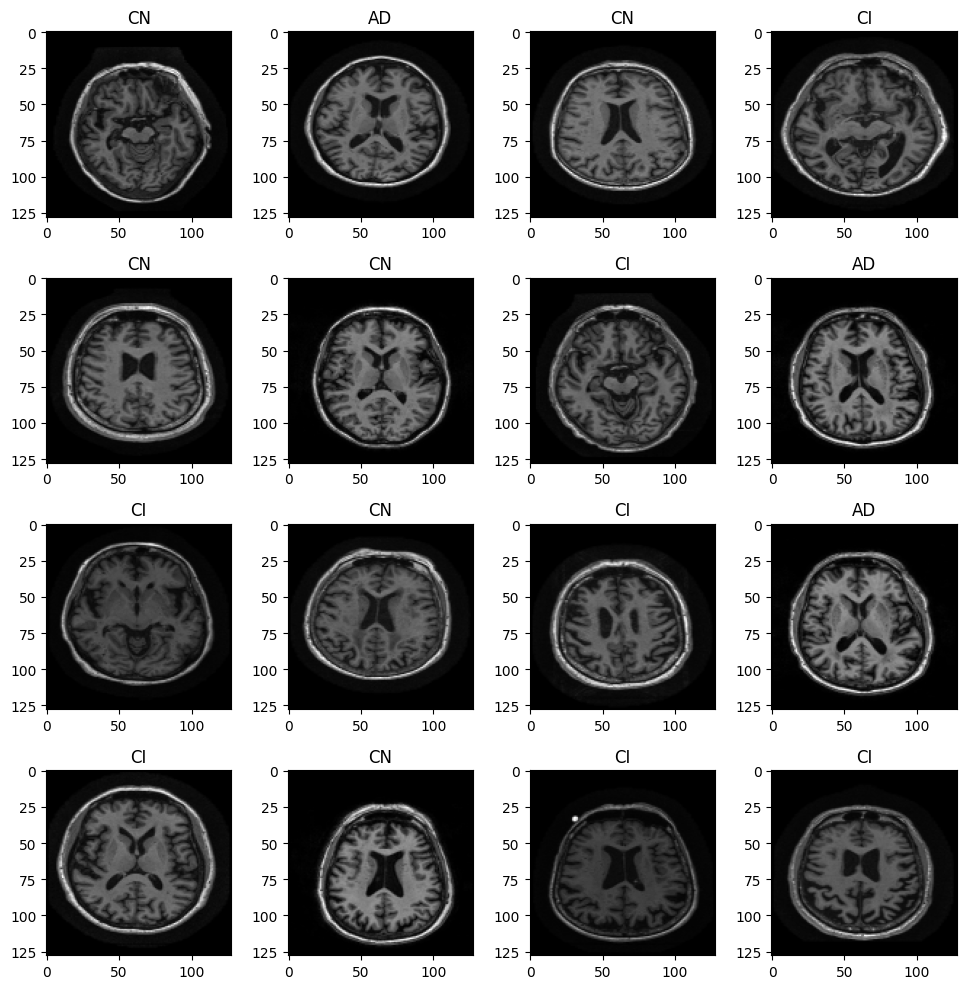

In [8]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

CN


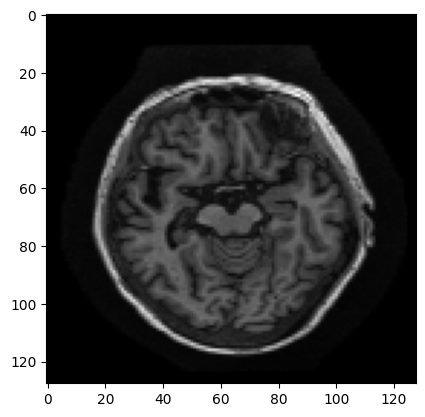

AD


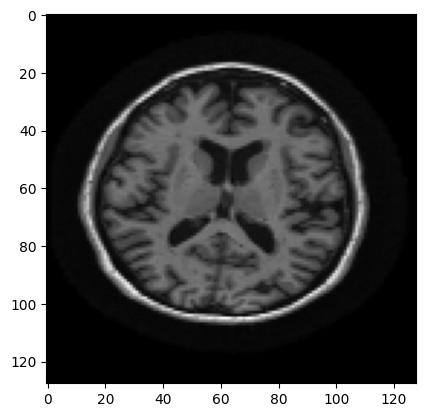

CI


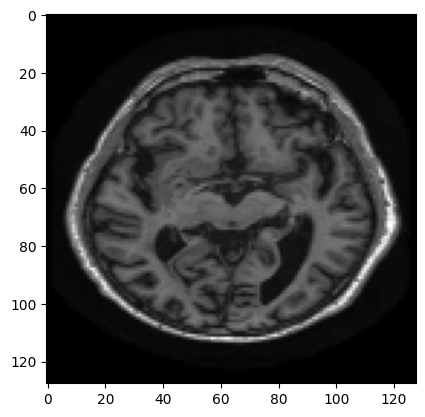

In [9]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [10]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


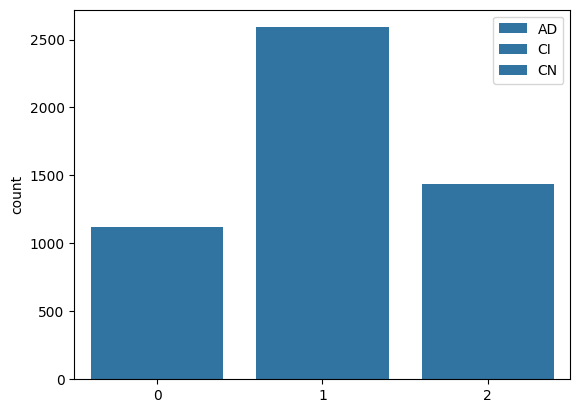

In [11]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

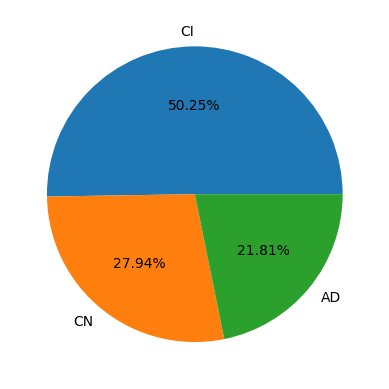

In [12]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()


### Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [14]:
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1

X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


In [15]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [16]:
print(pd.Series(y).value_counts())

2    3002
0    3002
1    3002
Name: count, dtype: int64


### Data Preprocessing and Preparation

In [17]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

0.0 0.9921568627450981


In [18]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15,
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15,
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6506, 128, 128, 1) (1149, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9006
Train instances: 6506           
Validation instances: 1149
Test instances: 1351


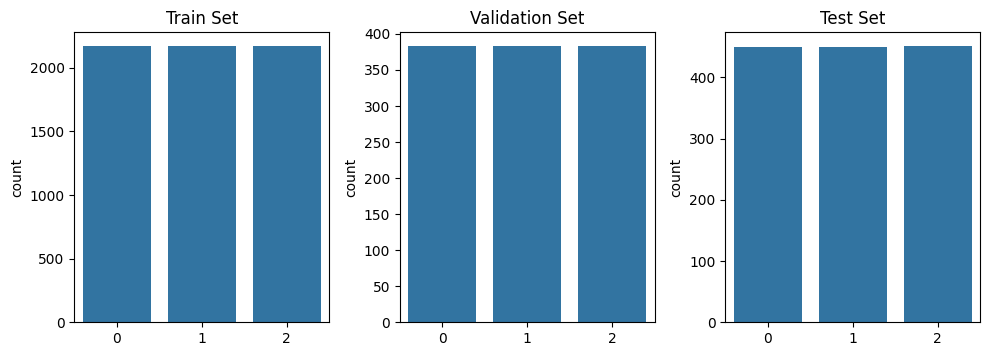

In [19]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

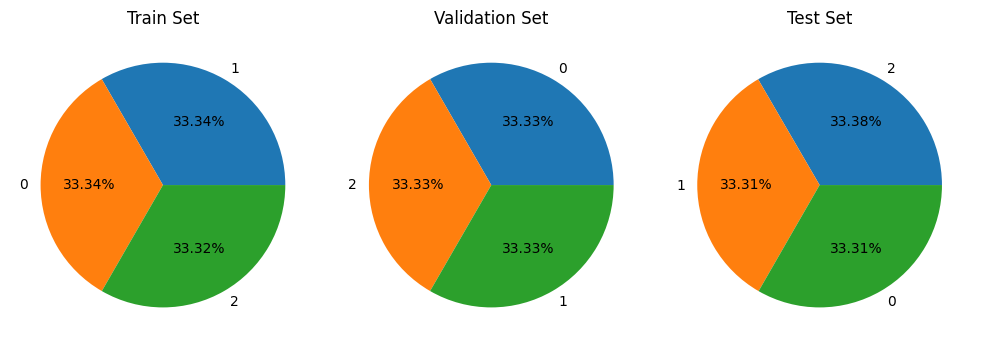

In [20]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

### Model Building and Training

In [21]:
# Model building

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 100, activation = "relu"),
    tf.keras.layers.Dense(units = 50, activation = "relu"),
    tf.keras.layers.Dense(units = 3, activation = "softmax")
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 200)     2000      
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 200)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 100)       180100    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 100)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16900)             0         
                                                                 
 dense (Dense)               (None, 100)              

In [23]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output_shape, layer.count_params())

Layer 0: conv2d (None, 126, 126, 200) 2000
Layer 1: max_pooling2d (None, 42, 42, 200) 0
Layer 2: conv2d_1 (None, 40, 40, 100) 180100
Layer 3: max_pooling2d_1 (None, 13, 13, 100) 0
Layer 4: flatten (None, 16900) 0
Layer 5: dense (None, 100) 1690100
Layer 6: dense_1 (None, 50) 5050
Layer 7: dense_2 (None, 3) 153


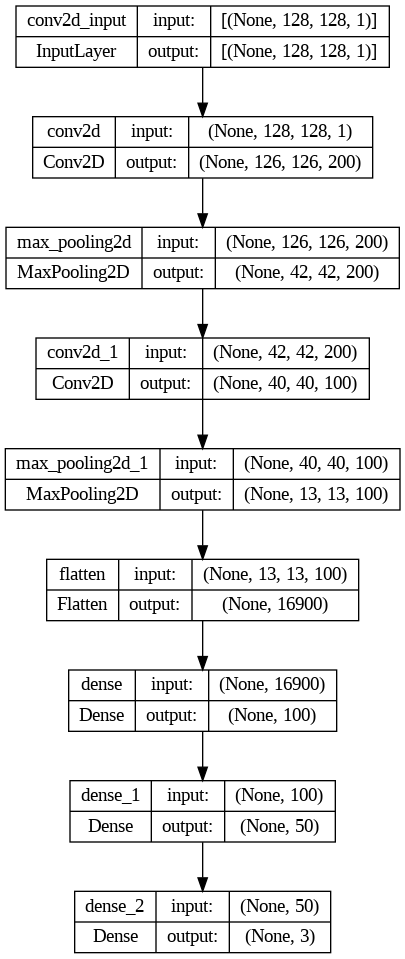

In [24]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

In [25]:
# Model compilation

model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [26]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.h5", save_best_only = True)
cb2 = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 100, callbacks = [cb1, cb2], validation_data = (X_val, y_val))

Epoch 1/100
204/204 [==============================] - 14s 46ms/step - loss: 0.9843 - accuracy: 0.4909 - val_loss: 0.7038 - val_accuracy: 0.6963
Epoch 2/100
204/204 [==============================] - 8s 39ms/step - loss: 0.5398 - accuracy: 0.7802 - val_loss: 0.4049 - val_accuracy: 0.8503
Epoch 3/100
204/204 [==============================] - 8s 38ms/step - loss: 0.2633 - accuracy: 0.9026 - val_loss: 0.2401 - val_accuracy: 0.9217
Epoch 4/100
204/204 [==============================] - 8s 39ms/step - loss: 0.1649 - accuracy: 0.9439 - val_loss: 0.1822 - val_accuracy: 0.9452
Epoch 5/100
204/204 [==============================] - 8s 38ms/step - loss: 0.0951 - accuracy: 0.9683 - val_loss: 0.2308 - val_accuracy: 0.9347
Epoch 6/100
204/204 [==============================] - 8s 39ms/step - loss: 0.0577 - accuracy: 0.9820 - val_loss: 0.1122 - val_accuracy: 0.9748
Epoch 7/100
204/204 [==============================] - 8s 37ms/step - loss: 0.0456 - accuracy: 0.9845 - val_loss: 0.1840 - val_accuracy

In [27]:
result_df = pd.DataFrame(history.history)
result_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.984284,0.490931,0.703825,0.696258
1,0.539798,0.780203,0.404899,0.850305
2,0.263262,0.902551,0.240068,0.921671
3,0.164921,0.943898,0.182165,0.945170
4,0.095088,0.968337,0.230802,0.934726


In [28]:
result_df.describe()

,loss,accuracy,val_loss,val_accuracy
count,17.000000,17.000000,17.000000,17.000000
mean,0.134089,0.941900,0.191087,0.942200
std,0.258498,0.128613,0.155678,0.072107
min,0.000112,0.490931,0.084143,0.696258
25%,0.001974,0.968337,0.102918,0.934726
50%,0.032765,0.989241,0.119754,0.974761
75%,0.095088,0.999693,0.227974,0.981723
max,0.984284,1.000000,0.703825,0.984334


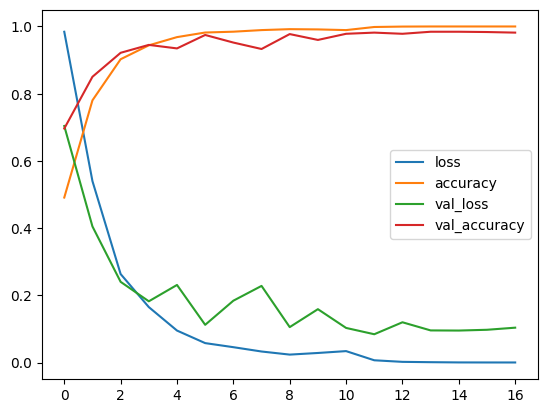

In [29]:
# Learning curves

result_df.plot()
plt.show()

In [30]:
# Evaluating the model on train set

loss, acc = model.evaluate(X_train, y_train)

204/204 [==============================] - 2s 10ms/step - loss: 0.0013 - accuracy: 0.9998


In [31]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 [==============================] - 2s 9ms/step
tf.Tensor(
[[2169    0    0]
 [   1 2168    0]
 [   0    0 2168]], shape=(3, 3), dtype=int32)


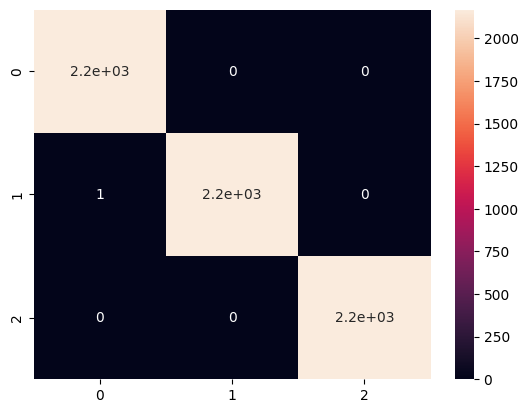

In [32]:
sns.heatmap(cm, annot = True)
plt.show()

In [33]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2169
True Negatives : 4336
False Positives : 1
False Negatives : 0

Precision : 0.9995391705069124
Recall (Sensitivity) : 1.0
F1-Score : 0.999769532150265


Class CI : 

True Positives : 2168
True Negatives : 4337
False Positives : 0
False Negatives : 1

Precision : 1.0
Recall (Sensitivity) : 0.9995389580451821
F1-Score : 0.9997694258704174


Class CN : 

True Positives : 2168
True Negatives : 4338
False Positives : 0
False Negatives : 0

Precision : 1.0
Recall (Sensitivity) : 1.0
F1-Score : 1.0


In [34]:
# Classification Report

clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169
           1       1.00      1.00      1.00      2169
           2       1.00      1.00      1.00      2168

    accuracy                           1.00      6506
   macro avg       1.00      1.00      1.00      6506
weighted avg       1.00      1.00      1.00      6506



### Model Validation

In [35]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 [==============================] - 1s 15ms/step - loss: 0.0908 - accuracy: 0.9808


43/43 [==============================] - 0s 9ms/step


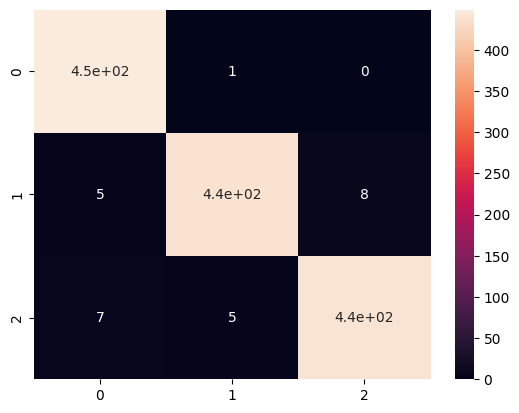

In [36]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [37]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 449
True Negatives : 889
False Positives : 12
False Negatives : 1

Precision : 0.9739696312364425
Recall (Sensitivity) : 0.9977777777777778
F1-Score : 0.9857299670691547


Class CI : 

True Positives : 437
True Negatives : 895
False Positives : 6
False Negatives : 13

Precision : 0.9864559819413092
Recall (Sensitivity) : 0.9711111111111111
F1-Score : 0.9787234042553191


Class CN : 

True Positives : 439
True Negatives : 892
False Positives : 8
False Negatives : 12

Precision : 0.9821029082774049
Recall (Sensitivity) : 0.9733924611973392
F1-Score : 0.977728285077951


In [38]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       450
           1       0.99      0.97      0.98       450
           2       0.98      0.97      0.98       451

    accuracy                           0.98      1351
   macro avg       0.98      0.98      0.98      1351
weighted avg       0.98      0.98      0.98      1351



### Saving the Model

In [39]:
model.save("clf_model_final.h5")